In [1]:
%pylab inline
import sympy as sym

Populating the interactive namespace from numpy and matplotlib


We'll need to compute

$$
A_{ij} := \int_a^b v_j' v_i' 
$$

and 

$$
f_i := \int_a^b v_i f
$$

We split the interval in $M$ elements (segments), with $M+1$ vertices (element boundaries). Define the element boundaries $q := [a, q_1, q_2, ..., q_{M-1}, b]$, and the elements sizes $h_k := v_{k+1}-q_k$. 
In $[a,b]$ we have a total of $N$ basis functions, which are piecewise polynomials of degree $d$, so that in each segment there are always at most $d+1$ non-zero basis functions, and $d+1$ support points.

We assume that each support point can be interpreted as the image of reference support points $\hat a_\alpha$, where $\alpha \in [0,d]$, throught the mapping $F_k(s) := q_k+h_k s$ which maps $[0,1]$ to $T_k := [q_k, q_{k+1}]$.


Similarly, every global basis function $v_j$ can be seen as the composition of a *reference* basis function $\hat v_\alpha$ defined on the reference interval $[0,1]$, and the inverse of the element transformation $F_k(s) := q_k+h_k s$ which maps $[0,1]$ to $[q_k, q_{k+1}]$, that is: 

$$
v_i(F_k(s)) = P_{ki\alpha} \hat v_\alpha(s)
$$

Where $P_{i\alpha}$ represents the numbering of the local basis function $\alpha \in [0,d]$, i.e., given the $(d+1)$ reference basis functions in $0,1$ of degree $d$, $P_{ki\alpha}$.

We will implement the numbering as a matrix $P \in R^{M,d+1}$, which returns the global index $i$, given the local element index $k$ and the local basis function index $i$, i.e., 


$$
v_{P_{k\alpha}}(F_k(s)) = \hat v_\alpha(s)
$$

Notice that, if we want to compute the derivative w.r.t. $x$ of $v_i$, computed in $F_k(s)$, as a function of the derivative of $\hat v_\alpha$ w.r.t. $s$, we need to take into account also the derivative of $F_k$, i.e., since $(v\circ F_k)' = (v' \circ F_k) F_k'$, we have


$$
v'_{P_{k\alpha}}(F_k(s)) = \hat v'_\alpha(s)/F'_k(s) = \hat v'_\alpha(s)/h_k
$$

In [2]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the 
# reference Basis functions

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: prod([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q,i,order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q,i)(t).diff(t,order))

In [3]:
def fem(M, exact_function, rhs_function, degree=1, a=0, b=1):
    """
    Solve the Finite Element Method with the given degree in 1d with M elements in [a,b], 
    for the given rhs_function, and return the L2 error w.r.t. to the given exact function.
    """
    assert degree > 0
    
    # We now choose the number of quadrature points, in order to integrate *exactly* 
    # both (v_i, v_j) and (v'_i, v'_j)
    n_quadrature_points = 2*degree+1
    # To get a continuous space, we construct piecewise polynomials with support points on the boundary of the
    # elements. If the degree is greater than 1, then we pick (d-1) equispaced points in the interior of the
    # elements as additional support points.

    # Notice that the total number of degrees of freedom is equal to the number of vertices (M+1) plus the 
    # number of *interior*  basis functions (d+1-2), that is: (M+1) + (d-1)*M = M*d+1
    N = M*degree+1
    ref_vertices = linspace(0,1,degree+1)
    vertices = linspace(a,b,M+1) # Vertices of our triangulation

    # Now construct a Gauss quadrature formula on [0,1]
    q, w = numpy.polynomial.legendre.leggauss(n_quadrature_points)
    q = (q+1)/2
    w = w/2

    
    Vq = array([lagrange_basis(ref_vertices,i)(q) for i in range(degree+1)]).T
    Vprimeq = array([lagrange_basis_derivative(ref_vertices,i)(q) for i in range(degree+1)]).T
    
    Bq = zeros((M, n_quadrature_points, N))
    Bprimeq = zeros((M, n_quadrature_points, N))

    # And build a global numbering of the basis functions i = P[k,alpha]. Keep in mind that, to ensure continuity, 
    # we identify the global index the first basis function of each element, with the global index of the 
    # last basis function of the previous element
    P = zeros((M,degree+1), dtype=int)

    for k in range(M):
        start = k*degree
        P[k] = array(range(start,start+degree+1))

    assert P.max() == N-1
    
    # Now we build, for each segment, the transformation of quadrature points and weights, so that we can 
    # integrate the rhs and the matrices
    Q = array([mapping(vertices,k)(q) for k in range(M)])
    JxW = array([mapping_J(vertices,k)*w for k in range(M)])
    
    # Construct a arrays Bq and Bprimeq: Bq[k,j,i] is v_i(T_k(q[j])), 
    # and Bprimeq[k,j,i] is v'_i(T_k(q[j]))/T'_k(q[j])    
    for k in range(M):
        Bq[k,:,P[k]] = Vq.T
        Bprimeq[k,:,P[k]] = Vprimeq.T/mapping_J(vertices,k)

    Xq = Q.flatten()
    Bq = Bq.reshape((len(Xq),-1))
    Bprimeq = Bprimeq.reshape((len(Xq),-1))
    JxWq = JxW.flatten()

    # Now compute the integrals for the stiffness matrix
    stiffness_matrix = einsum('qi,qj,q',Bprimeq,Bprimeq,JxWq)
    stiffness_matrix[0,:] = stiffness_matrix[-1,:] = 0
    stiffness_matrix[0,0] = stiffness_matrix[-1,-1] = 1 
    
    # And the integral for the rhs
    rhs = einsum('qi,q,q', Bq, rhs_function(Xq), JxWq)
    rhs[0] = exact_function(a)
    rhs[-1] = exact_function(b)
    
    # Finally solve the system
    u = linalg.solve(stiffness_matrix, rhs)
    # And compute the L2 error: 
    error = sqrt(einsum('q,q', (Bq.dot(u)-exact_function(Xq))**2, JxWq))
    return error
    

In [4]:
# Let's solve non trivial problem: u = sin(2 pi x)  --> -u'' = 4 pi^2 sin(2 pi x) 
def exact_function(x):
    return sin(2*pi*x)

def rhs_function(x):
    return sin(2*pi*x)*(4*pi**2)

In [5]:
fem(6, exact_function, rhs_function, 3)

0.00027868305314870966

In [6]:
degrees = [1,2,3,4]
Ms = [2**cycle for cycle in range(3,9)]
h = [1/(M+1) for M in Ms]

errors = zeros((len(h), len(degrees)))

for i in range(len(Ms)):
    for j in range(len(degrees)):
        errors[i,j] = fem(Ms[i], exact_function, rhs_function, degrees[j])

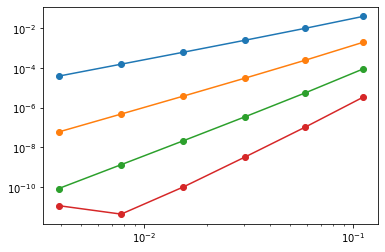

In [7]:
_ = loglog(h, errors,'o-')